In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [2]:
def load_mnist(n_samples, root_path, training=True):
    ''' 
    Loads, downloads and sets MNIST up
    returns train DataLoader
    '''
    X_ = datasets.MNIST(root=root_path, train=training, download=True,
                            transform=transforms.Compose([transforms.ToTensor()]))

    idx = np.append(np.where(X_.targets == 0)[0][:n_samples],
                   np.where(X_.targets == 1)[0][:n_samples])

    X_.data = X_.data[idx]
    X_.targets = X_.targets[idx]

    return torch.utils.data.DataLoader(X_, batch_size=1, shuffle=True)

In [3]:
def load_olivetti(plot=False, c1=1, c2=3):
    # Olivetti images already come normalized
    import os
    path = '../datasets/olivetti'
    data = np.load(os.path.join(path, 'olivetti_faces.npy'))
    labels = np.load(os.path.join(path, 'olivetti_faces_target.npy'))
        
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=0)
    
    # Normalize images to [0, 1]
    x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]
    
    print('Number of original training examples:', len(x_train))
    print('Number of original test examples:', len(x_test))
    
    # Filter labels c1 and c2
    x_train, y_train = filter_labels(x_train, y_train, c1, c2)
    x_test, y_test = filter_labels(x_test, y_test, c1, c2)

    print('Number of filtered training examples:', len(x_train))
    print('Number of filtered test examples:', len(x_test))
    
    # Transform labels into 0 or 1 classes
    #y_train = y_train.astype(int)
    #y_test = y_test.astype(int)
    
    print(x_train.shape)
    if plot:
        # Show the first image
        plt.imshow(x_train[0, :, :, 0])
        plt.colorbar()
        
    return x_train, y_train, x_test, y_test

In [4]:
def display_sample(n_samples, loader):
    data_iter = iter(loader)
    fig, axes = plt.subplots(nrows=1, ncols=n_samples, figsize=(10, 3))

    for sample in reversed(range(n_samples)):
        images, targets = data_iter.__next__()

        axes[sample].imshow(images[0].numpy().squeeze(), cmap='gray')
        axes[sample].set_xticks([])
        axes[sample].set_yticks([])
        axes[sample].set_title("Labeled: {}".format(targets.item()))

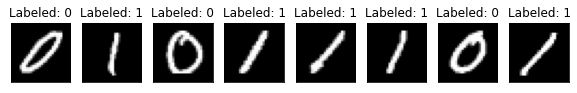

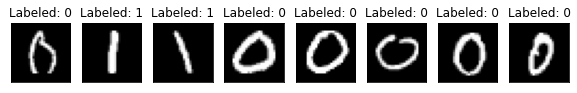

In [5]:
train_mnist = load_mnist(100, '../datasets', training=True)
test_mnist = load_mnist(50, '../datasets', training=False)

# Training samples display
display_sample(8, train_mnist)
# Testing samples display
display_sample(8, test_mnist)

In [6]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        
        self.backend = backend
        self.shots = shots
        
    def run(self, thetas):
        t_qc = transpile(self._circuit, self.backend)
        qobj = assemble(t_qc, shots=self.shots,
                       parameter_binds=[{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        if (len(thetas) > 1):
            result = job.result().get_counts(self._circuit)
        else:
            result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        probabilities = counts / self.shots
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [7]:
def test_circuit():
    simulator = qiskit.Aer.get_backend('qasm_simulator')

    circuit = QuantumCircuit(1, simulator, 100)
    print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
    circuit._circuit.draw()

In [8]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        
        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)
            
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None
    
class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1-x), -1)

In [10]:
def net_process(epochs, train_loader, test_loader, plot_losses=False):
    model = Net()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_f = nn.NLLLoss()
    losses = []

    model.train()
    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            # Forward
            output = model(data)
            # Calculating loss
            loss = loss_f(output, target)
            # Backward
            loss.backward()
            optimizer.step()

            total_loss.append(loss.item())
        losses.append(sum(total_loss)/len(total_loss))
        print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
            100. * (epoch + 1) / epochs, losses[-1]))
        
    if plot_losses:
        plt.plot(losses)
        plt.title('Hybrid NN Training Convergence')
        plt.xlabel('Training Iterations')
        plt.ylabel('Neg Log Likelihood Loss')
        
    ''' Training is finished, so we need to do the testing '''
    model.eval()
    with torch.no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            loss = loss_f(output, target)
            total_loss.append(loss.item())

        print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
            sum(total_loss) / len(total_loss),
            correct / len(test_loader) * 100)
            )
        
    return model

In [11]:
def test_display_sample(n_samples, loader, model):
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples, figsize=(10, 3))

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            if count == n_samples:
                break
            output = model(data)

            pred = output.argmax(dim=1, keepdim=True)
            confidence = output[:, pred][0][0]

            axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title('Predicted {}'.format(pred.item()))

            count += 1

Training [5%]	Loss: -0.7749
Training [10%]	Loss: -0.9366
Training [15%]	Loss: -0.9346
Training [20%]	Loss: -0.9431
Training [25%]	Loss: -0.9502
Training [30%]	Loss: -0.9584
Training [35%]	Loss: -0.9608
Training [40%]	Loss: -0.9755
Training [45%]	Loss: -0.9783
Training [50%]	Loss: -0.9733
Training [55%]	Loss: -0.9747
Training [60%]	Loss: -0.9799
Training [65%]	Loss: -0.9793
Training [70%]	Loss: -0.9850
Training [75%]	Loss: -0.9794
Training [80%]	Loss: -0.9906
Training [85%]	Loss: -0.9889
Training [90%]	Loss: -0.9859
Training [95%]	Loss: -0.9891
Training [100%]	Loss: -0.9909
Performance on test data:
	Loss: -0.9768
	Accuracy: 100.0%


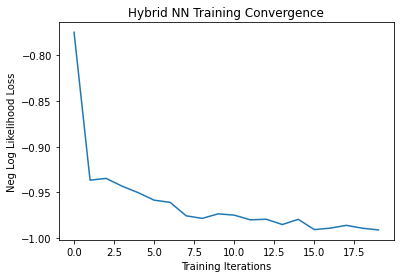

In [12]:
model = net_process(20, train_mnist, test_mnist, plot_losses=True)

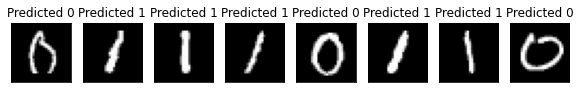

In [13]:
test_display_sample(8, test_mnist, model)